In [1]:
# Install required packages  
%pip install chunkr_ai pandas beautifulsoup4 lxml pydantic matplotlib numpy seaborn

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Upload the Excel file to Chunkr for processing
from chunkr_ai import Chunkr
chunkr = Chunkr(api_key="YOUR_API_KEY") # Replace with your actual API key

# Processing the Department of Education Fiscal Year 2020 Congressional Action excel file
task = await chunkr.upload("https://data.ed.gov/dataset/3683c899-b7b5-4ad4-9b5d-152d197ab389/resource/f5d00bcf-b58e-4914-ba29-a03440e63a9f/download/20action.xlsx")

In [3]:
import pandas as pd
from bs4 import BeautifulSoup
from io import StringIO

# Helper function to convert Chunkr's HTML table output to a pandas DataFrame.
def parse_table_html(html_content):
    """
    Convert Chunkr HTML table to pandas DataFrame
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    thead = soup.find('thead')
    
    if thead:
        num_header_rows = len(thead.find_all('tr'))
        header_param = list(range(num_header_rows)) if num_header_rows > 1 else 0
    else:
        header_param = 0
    
    tables = pd.read_html(StringIO(html_content), header=header_param)
    return tables[0]

In [4]:
from pydantic import BaseModel, Field, ConfigDict
from chunkr_ai.models import Segment
import uuid

class Table(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    
    id: str = Field(default_factory=lambda: str(uuid.uuid4()))
    segment: Segment
    df: pd.DataFrame

# Chunkr splits the Excel file into multiple segments, including tables.
# We'll parse each table segment into a pandas DataFrame.
tables = [
    Table(segment=segment, df=parse_table_html(segment.content))
    for chunk in task.output.chunks
    for segment in chunk.segments
    if segment.segment_type == "Table"
]
print(f"Found {len(tables)} tables in the document.")
print("Sample of the first table:")
tables[0].df.head()

Found 38 tables in the document.
Sample of the first table:


,Education for the Disadvantaged,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,Unnamed: 4_level_0,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,Unnamed: 8_level_0,Unnamed: 9_level_0,Unnamed: 10_level_0
,Program,Cat Code,2019 Appropriation,2020 President's Budget,2020 House,2020 Senate Mark,2020 Appropriation,2020 Appropriation Compared to 2019 Appropriation Amount,2020 Appropriation Compared to 2019 Appropriation Percent,2020 Appropriation Compared to 2020 President's Budget Amount,2020 Appropriation Compared to 2020 President's Budget Percent
0,1.Grants to local educational agencies (ESEA I...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a.Basic grants (section 1124),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Annual appropriation,D,5018625.0,4177904.0,6018625.0,5018625.0,5468625.0,450000,8.97%,1290721,30.89%
3,Advance for succeeding fiscal year,D,1440776.0,2281497.0,440776.0,1440776.0,990776.0,"(450,000)",(31.23%),"(1,290,721)",(56.57%)
4,Subtotal,NaN,6459401.0,6459401.0,6459401.0,6459401.0,6459401.0,0,0.00%,0,0.00%


In [5]:
# Pydantic models for structuring the extracted program data.
class ProgramRow(BaseModel):
    cat_code: str
    appropriation_2019: float
    president_budget_2020: float
    house_2020: float
    senate_mark_2020: float
    appropriation_2020: float
    change_from_2019_amount: float
    change_from_2019_percent: str
    change_from_president_amount: float
    change_from_president_percent: str

    @classmethod
    def from_pd_series(cls, series: pd.Series) -> 'ProgramRow':
        """Convert pandas Series to ProgramRow, handling data cleaning"""
        
        def get_val(key, as_float=False):
            """Get value from series with optional float conversion"""
            try:
                val = series.get(key, 0.0 if as_float else '')
                if isinstance(val, pd.Series):
                    val = val.iloc[0] if not val.empty else (0.0 if as_float else '')
                if as_float:
                    if pd.isna(val): return 0.0
                    return float(str(val).replace(',', '').replace('(', '-').replace(')', '').strip() or '0')
                return '' if pd.isna(val) else str(val)
            except: 
                return 0.0 if as_float else ''
        
        return cls(
            cat_code=get_val('Unnamed: 1_level_0'),
            appropriation_2019=get_val('Unnamed: 2_level_0', True),
            president_budget_2020=get_val('Unnamed: 3_level_0', True),
            house_2020=get_val('Unnamed: 4_level_0', True),
            senate_mark_2020=get_val('Unnamed: 5_level_0', True),
            appropriation_2020=get_val('Unnamed: 6_level_0', True),
            change_from_2019_amount=get_val('Unnamed: 7_level_0', True),
            change_from_2019_percent=get_val('Unnamed: 8_level_0'),
            change_from_president_amount=get_val('Unnamed: 9_level_0', True),
            change_from_president_percent=get_val('Unnamed: 10_level_0')
        )

class ProgramTotal(BaseModel):
    program: str
    row: ProgramRow
 
program_data: list[ProgramTotal] = []

# Extract the 'Total' rows from each table, as they contain the program summary data.
program_data = [
    ProgramTotal(
        program=row.index[0][0],
        row=ProgramRow.from_pd_series(row)
    )
    for table in tables
    for _, row in table.df.iterrows()
    if row[0] in ["Total", "Total, Appropriation"]
]

print("Sample of the program data:")
print(program_data[0])

Sample of the program data:
program='Education for the Disadvantaged' row=ProgramRow(cat_code='D', appropriation_2019=16543790.0, president_budget_2020=16376790.0, house_2020=17563802.0, senate_mark_2020=16543790.0, appropriation_2020=16996790.0, change_from_2019_amount=453000.0, change_from_2019_percent='2.74%', change_from_president_amount=620000.0, change_from_president_percent='3.79%')


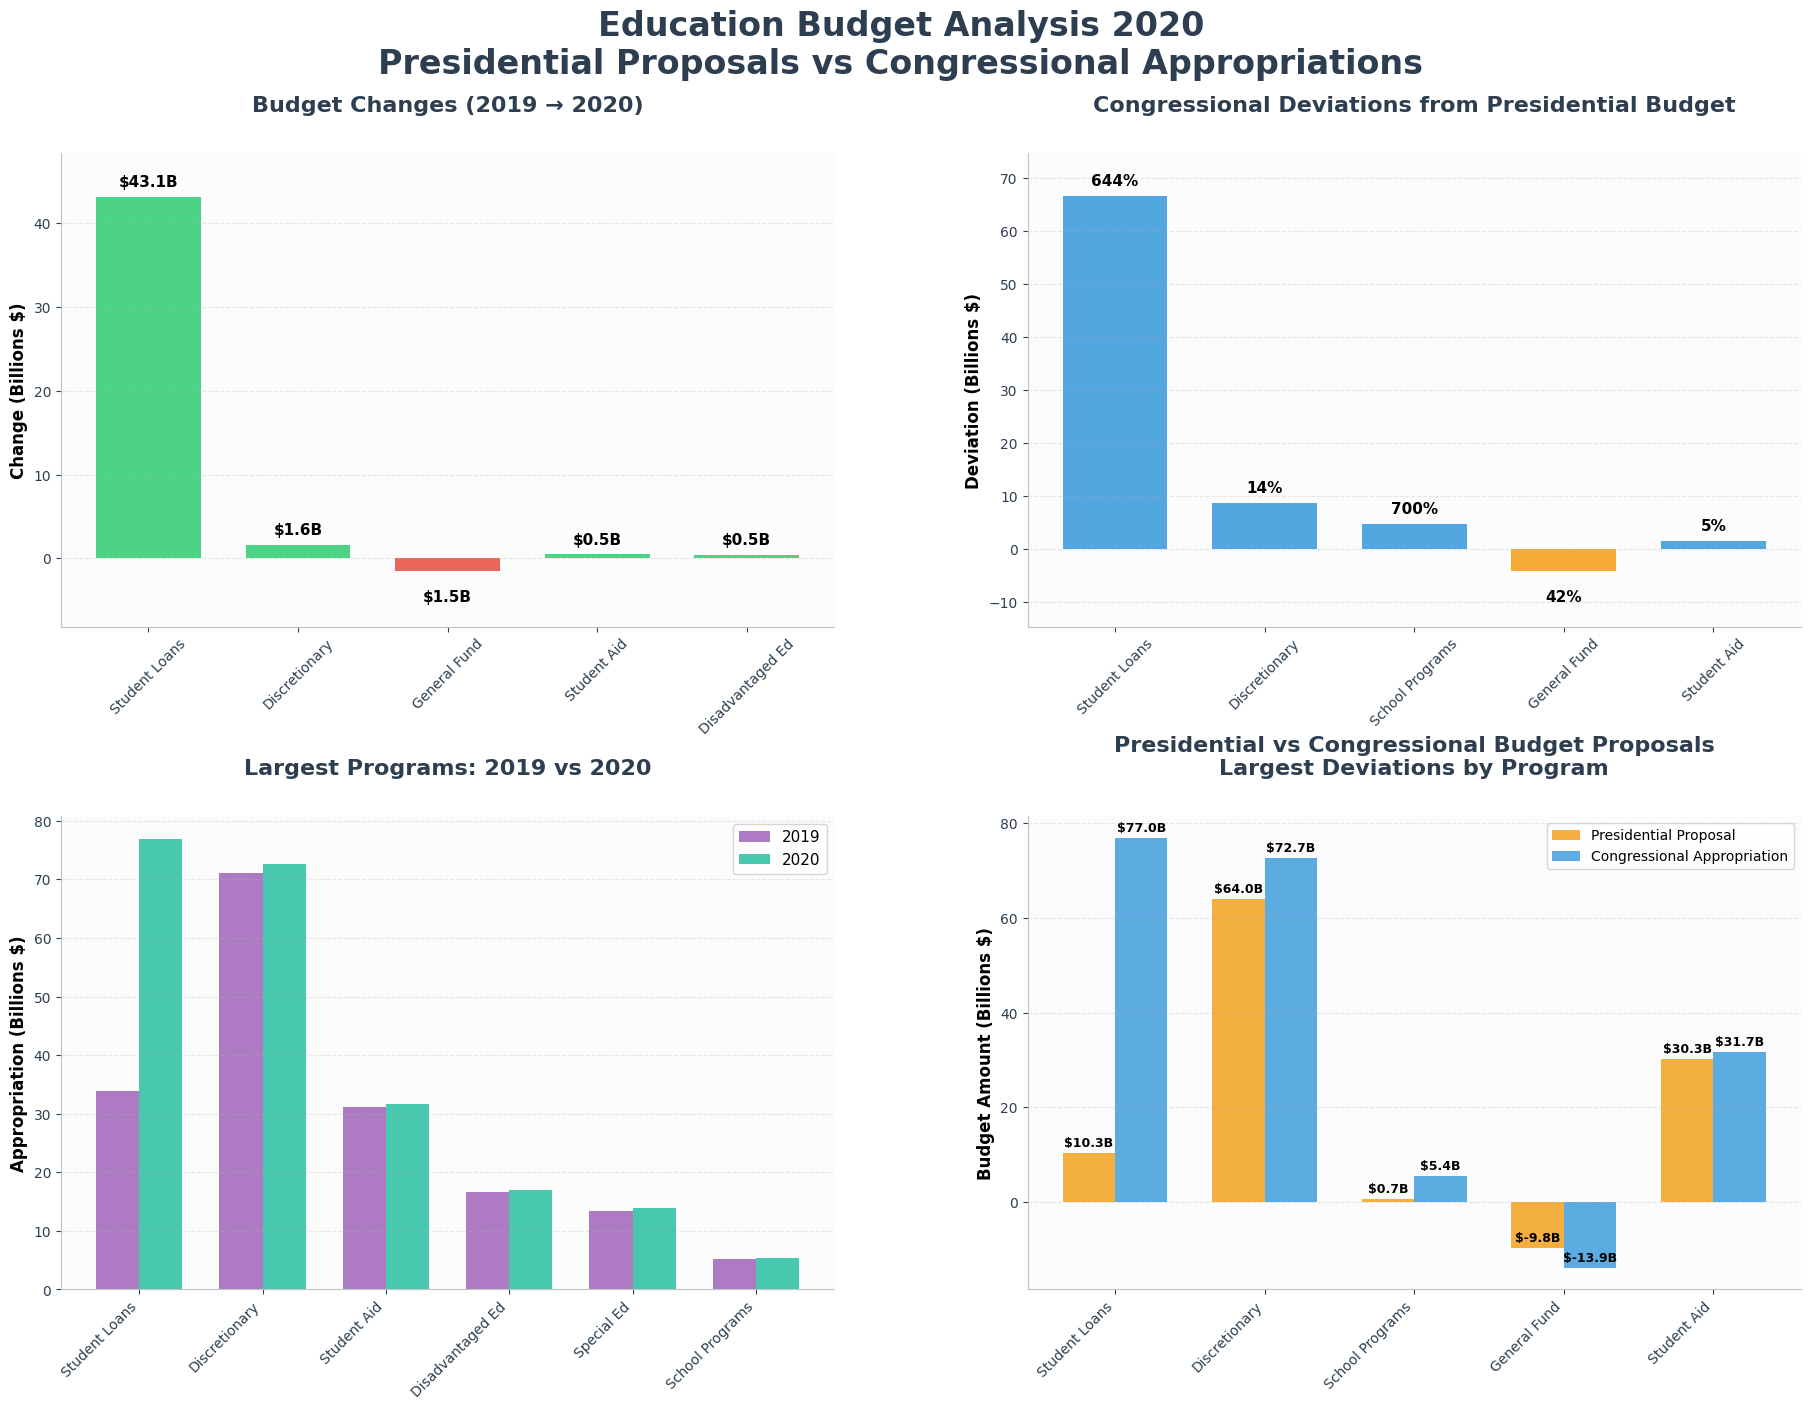

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Create a dashboard from the program data
def create_dashboard(program_data):
    """Create a dashboard"""
    
    programs = [p.program for p in program_data]
    appropriation_2019 = [p.row.appropriation_2019 for p in program_data]
    appropriation_2020 = [p.row.appropriation_2020 for p in program_data]
    change_from_2019 = [p.row.change_from_2019_amount for p in program_data]
    change_from_president = [p.row.change_from_president_amount for p in program_data]
    change_from_president_pct = [float(str(p.row.change_from_president_percent).replace('%', '').replace('(', '-').replace(')', '').replace('---', '0').strip() or '0') for p in program_data]
    
    fig = plt.figure(figsize=(20, 16))
    fig.patch.set_facecolor('white')
    
    def clean_program_name(prog):
        if "Federal Direct Student Loans" in prog:
            return "Student Loans"
        elif "DISCRETIONARY APPROP" in prog:
            return "Discretionary"
        elif "Student Financial Assistance" in prog:
            return "Student Aid"
        elif "Education for the Disadvantaged" in prog:
            return "Disadvantaged Ed"
        elif "School Improvement" in prog:
            return "School Programs"
        elif "Special Education" in prog:
            return "Special Ed"
        elif "Higher Education" in prog:
            return "Higher Ed"
        elif "General Fund" in prog:
            return "General Fund"
        return prog[:15]
    
    ax1 = plt.subplot(2, 2, 1)
    impact_data = list(zip(programs, change_from_2019))
    impact_data.sort(key=lambda x: abs(x[1]), reverse=True)
    top_5_changes = impact_data[:5]
    
    names = [clean_program_name(prog) for prog, _ in top_5_changes]
    values = [x[1]/1000000 for x in top_5_changes]
    colors = ['#2ECC71' if x > 0 else '#E74C3C' for x in values]
    
    bars = ax1.bar(names, values, color=colors, alpha=0.85, width=0.7)
    
    y_range = max(values) - min(values)
    if min(values) < 0:
        ax1.set_ylim(min(values) - y_range * 0.15, max(values) * 1.12) 
    else:
        ax1.set_ylim(0, max(values) * 1.12)
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        if height > 0:
            label_y = height + y_range * 0.02
            va = 'bottom'
        else:
            label_y = height - y_range * 0.05
            va = 'top'
        ax1.text(bar.get_x() + bar.get_width()/2., label_y,
                f'${abs(val):.1f}B', ha='center', va=va,
                fontweight='bold', fontsize=11)
    
    ax1.set_title('Budget Changes (2019 → 2020)', fontsize=16, fontweight='bold', 
                  pad=30, color='#2C3E50')
    ax1.set_ylabel('Change (Billions $)', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    ax2 = plt.subplot(2, 2, 2)
    pres_impact = list(zip(programs, change_from_president, change_from_president_pct))
    pres_impact.sort(key=lambda x: abs(x[1]), reverse=True)
    top_5_deviations = pres_impact[:5]
    
    names_2 = [clean_program_name(prog) for prog, _, _ in top_5_deviations]
    values_2 = [x[1]/1000000 for x in top_5_deviations]
    colors_2 = ['#3498DB' if x > 0 else '#F39C12' for x in values_2]
    
    bars2 = ax2.bar(names_2, values_2, color=colors_2, alpha=0.85, width=0.7)
    
    y_range_2 = max(values_2) - min(values_2)
    if min(values_2) < 0:
        ax2.set_ylim(min(values_2) - y_range_2 * 0.15, max(values_2) * 1.12)
    else:
        ax2.set_ylim(0, max(values_2) * 1.12)
    
    for bar, (_, _, pct) in zip(bars2, top_5_deviations):
        height = bar.get_height()
        if height > 0:
            label_y = height + y_range_2 * 0.02
            va = 'bottom'
        else:
            label_y = height - y_range_2 * 0.05
            va = 'top'
        ax2.text(bar.get_x() + bar.get_width()/2., label_y,
                f'{abs(pct):.0f}%', ha='center', va=va,
                fontweight='bold', fontsize=11)
    
    ax2.set_title('Congressional Deviations from Presidential Budget', fontsize=16, 
                  fontweight='bold', pad=30, color='#2C3E50')
    ax2.set_ylabel('Deviation (Billions $)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45, labelsize=10)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    ax3 = plt.subplot(2, 2, 3)
    largest_programs = list(zip(programs, appropriation_2019, appropriation_2020))
    largest_programs.sort(key=lambda x: x[2], reverse=True)
    top_6_programs = largest_programs[:6]
    
    names_3 = [clean_program_name(prog) for prog, _, _ in top_6_programs]
    values_2019 = [x[1]/1000000 for x in top_6_programs]
    values_2020 = [x[2]/1000000 for x in top_6_programs]
    
    x_pos = np.arange(len(names_3))
    width = 0.35
    
    ax3.bar(x_pos - width/2, values_2019, width, label='2019', 
            color='#9B59B6', alpha=0.8)
    ax3.bar(x_pos + width/2, values_2020, width, label='2020', 
            color='#1ABC9C', alpha=0.8)
    
    ax3.set_title('Largest Programs: 2019 vs 2020', fontsize=16, fontweight='bold', 
                  pad=30, color='#2C3E50')
    ax3.set_ylabel('Appropriation (Billions $)', fontsize=12, fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(names_3, rotation=45, ha='right', fontsize=10)
    ax3.legend(fontsize=11, frameon=True)
    ax3.grid(axis='y', alpha=0.3, linestyle='--')
    
    ax4 = plt.subplot(2, 2, 4)
    
    # Find programs with highest deviation between presidential proposal and congressional appropriation
    president_budgets = [p.row.president_budget_2020 for p in program_data]
    deviation_data = list(zip(programs, president_budgets, appropriation_2020, change_from_president))
    
    # Sort by absolute deviation to find the biggest disagreements
    deviation_data.sort(key=lambda x: abs(x[3]), reverse=True)
    top_5_deviations = deviation_data[:5]
    
    names_4 = [clean_program_name(prog) for prog, _, _, _ in top_5_deviations]
    pres_values = [x[1]/1000000 for x in top_5_deviations]  # Presidential proposal
    congress_values = [x[2]/1000000 for x in top_5_deviations]  # Congressional appropriation
    
    x_pos = np.arange(len(names_4))
    width = 0.35
    
    # Create side-by-side bars showing presidential vs congressional amounts
    bars_pres = ax4.bar(x_pos - width/2, pres_values, width, label='Presidential Proposal', 
                       color='#F39C12', alpha=0.8)
    bars_congress = ax4.bar(x_pos + width/2, congress_values, width, label='Congressional Appropriation', 
                           color='#3498DB', alpha=0.8)
    
    # Add value labels on bars
    for i, (pres_val, congress_val) in enumerate(zip(pres_values, congress_values)):
        # Label for presidential proposal
        ax4.text(x_pos[i] - width/2, pres_val + max(max(pres_values), max(congress_values)) * 0.01,
                f'${pres_val:.1f}B', ha='center', va='bottom', fontweight='bold', fontsize=9)
        # Label for congressional appropriation  
        ax4.text(x_pos[i] + width/2, congress_val + max(max(pres_values), max(congress_values)) * 0.01,
                f'${congress_val:.1f}B', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax4.set_title('Presidential vs Congressional Budget Proposals\nLargest Deviations by Program', 
                  fontsize=16, fontweight='bold', pad=30, color='#2C3E50')
    ax4.set_ylabel('Budget Amount (Billions $)', fontsize=12, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(names_4, rotation=45, ha='right', fontsize=10)
    ax4.legend(fontsize=10, frameon=True, loc='upper right')
    ax4.grid(axis='y', alpha=0.3, linestyle='--')
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#BDC3C7')
        ax.spines['bottom'].set_color('#BDC3C7')
        ax.tick_params(colors='#2C3E50')
        ax.set_facecolor('#FCFCFC')
    
    fig.suptitle('Education Budget Analysis 2020\nPresidential Proposals vs Congressional Appropriations', 
                fontsize=24, fontweight='bold', y=0.94, color='#2C3E50')
    plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.14, 
                       hspace=0.4, wspace=0.25)
    plt.show()
    return fig

_dashboard = create_dashboard(program_data)